In [9]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

from sklearn.linear_model import RidgeClassifier, LogisticRegression

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.stat.classification import binary_classifier
# from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.pandas_helper import merge_df_from_dict
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.utils.plotting import imshow

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity, rstest_twosided
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [5]:
dataDB = BehaviouralNeuronalDatabase(params)

In [6]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [7]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


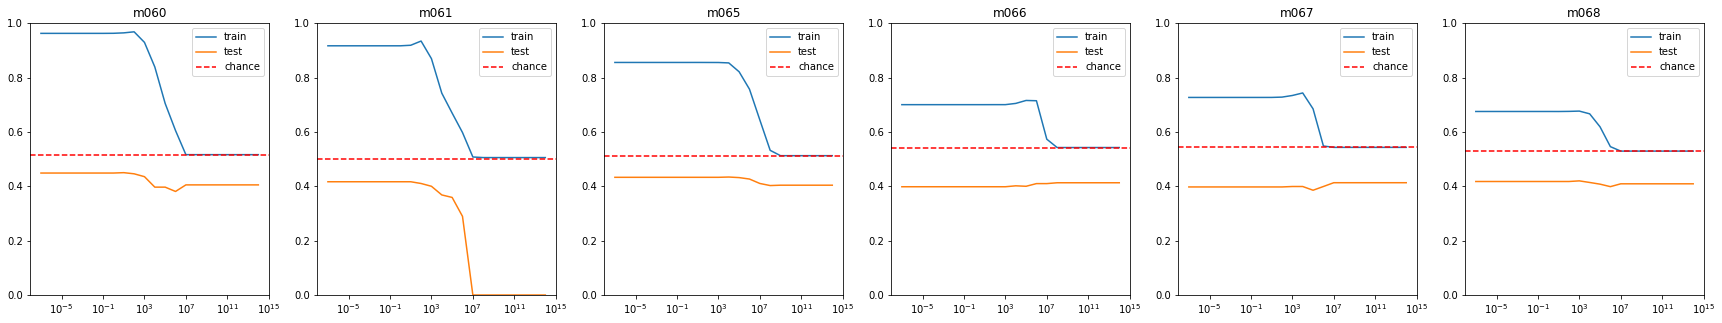

In [21]:
def cross_validate(dataDB, datatype, selector):
    CLst = 10.0**np.arange(-7, 15)

    nMice = len(dataDB.mice)
    fig, ax = plt.subplots(ncols=nMice, figsize=(5*nMice, 5))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print('Doing mouse', mousename)

        queryDictL = {'datatype' : datatype, 'mousename' : mousename, 'direction' : 'L'}
        queryDictR = {'datatype' : datatype, 'mousename' : mousename, 'direction' : 'R'}

        dataL = metric_by_selector(dataDB, queryDictL, 'mean', 'rp', selector, {})
        dataR = metric_by_selector(dataDB, queryDictR, 'mean', 'rp', selector, {})

        rezLst = []
        for C in CLst:
        #     classifier = LogisticRegression(max_iter=10000, C=C, penalty='l1', solver='liblinear')
#             classifier = LogisticRegression(max_iter=10000, C=C)
            classifier = RidgeClassifier(max_iter=10000, alpha=C)
            rezLst += [binary_classifier(dataL, dataR, classifier, havePVal=True, method='looc')]

        df = pd.DataFrame(rezLst)
        # display(df)

        ax[iMouse].set_title(mousename)
        ax[iMouse].semilogx(CLst, df['accTrain'], label='train')
        ax[iMouse].semilogx(CLst, df['accTest'], label='test')
        ax[iMouse].axhline(y=df['accNaive'][0], linestyle='--', color='r', label='chance')
        ax[iMouse].set_ylim([0,1])
        ax[iMouse].legend()
    plt.show()
    
cross_validate(dataDB, 'raw', {'interval' : 8})

In [3]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"serial": True, "metricSettings": None}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings)

rez

NameError: name 'plots_lib' is not defined

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)